In [65]:
using Random
using Distributions
using LinearAlgebra
include("../../Inversion/Plot.jl")
include("../../Inversion/RWMCMC.jl")
include("../../Inversion/SMC.jl")
include("../../Inversion/KalmanInversion.jl")

solve_β (generic function with 2 methods)

# 1-Parameter Square Map
The posterior distribution is studied  numerically on the following nonlinear 1-parameter problem:

$$
\begin{equation*}
y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \theta^2. 
\end{equation*}
$$    


We assume the observation is $y = 1$ and the piror is $\mathcal{N}(3, 2^2)$, we consider the following cases

$$
\begin{align*}
&A: \eta \sim \mathcal{N}(0, 1^2)\\
&B: \eta \sim \mathcal{N}(0, 0.5^2)\\
&C: \eta \sim \mathcal{N}(0, 0.2^2)\\
\end{align*}
$$ 

In [66]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

function p1(s_param, θ::Array{Float64,1})  
    return [θ[1] ;]
end

function p1_aug(s_param, θ::Array{Float64,1})  
    return [θ[1] ; θ[1]]
end

function p1_aug_derivative(s_param, θ::Array{Float64,1})  
    return [θ[1] ; θ[1]], [1.0 ; 1.0]
end



function p2(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ;]
end

function p2_aug(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ; θ[1]]
end

function p2_aug_derivative(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ; θ[1]], [2θ[1] ; 1.0]
end

p2_aug_derivative (generic function with 1 method)

# Numerical Methods

The posterior distribution is approximated by 
* MCMC method (reference):  a step size $1.0$ and $5\times10^6$ samples (with a $10^6$ sample burn-in period).
* SMC method: $10^3$ particles and $10^2$ uniform steps is also applied for comparison. 
* UKI method: $2$ initial conditions are considered, which are $\theta_0\sim\mathcal{N}(-1, 0.5^2)$ and $\theta_0\sim\mathcal{N}(1, 0.5^2)$. We find that only the hyperbola discontinuous problem is sensitive to the initial covariance for the UKI. The hyperparameters of UKI are chosen at the $n$-th iteration, as following
$$ r = r_0 \quad
    \Sigma_{\nu} = 2\Sigma_{\eta} \quad \textrm{ and } \quad \Sigma_{\omega} =  C_n
$$
here $r_0$ is the prior mean. It is worth mentioning the artificial evolution error covariance $\Sigma_{\omega}$ is updated as the estimated covariance $C_{n}$.

In [67]:
function Posterior_Plot(forward::Function;  θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0, 
                        Run_EKS = false, Run_SMC = false, Run_MCMC = false, plot_every = 1)
    
    forward_aug = (s_param, θ) -> vcat(forward(s_param, θ), θ)
    
    N_y, N_θ = 1, 1
    s_param = Setup_Param(N_θ, N_y)
    y = forward(s_param, [θ_ref;])
    Σ_η = reshape([σ_η^2], (N_y, N_y))
    # prior distribution
    μ0,  Σ0   = [μ_0;], reshape([σ_0^2],  (N_θ, N_θ))
    


    # compute posterior distribution by UKI
    update_freq = 1
    N_iter = 30
    N_modes = 3
    θ0_w  = fill(1.0, N_modes)/N_modes
    θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)
    
    θ0_mean[1, :]    .= -3.0
    θθ0_cov[1, :, :] .=  reshape([0.5^2],  (1, 1))
    θ0_mean[2, :]    .=  3.0
    θθ0_cov[2, :, :] .=  reshape([0.5^2],  (1, 1))
    θ0_mean[3, :]    .=  -2.0
    θθ0_cov[3, :, :] .=  reshape([0.5^2],  (1, 1))
    
    s_param_aug = Setup_Param(1,2)
    y_aug = [y ; μ0]
    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
    γ = 1.0
    # Δt = γ/(1+γ)
    ukiobj = GMUKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, γ, update_freq, N_iter; unscented_transform="modified-2n+1")
    


    if Run_MCMC
        # compute posterior distribution by MCMC
        logρ(θ) = log_bayesian_posterior(s_param, θ, forward, y, Σ_η, μ0, Σ0) 
        step_length = 1.0
        N_iter , n_burn_in= 5000000, 1000000
        us = RWMCMC_Run(logρ, μ0, step_length, N_iter)
    end
    
    # compute posterior distribution by SMC
    if Run_SMC
        N_ens = 1000
        M_threshold = Float64(N_ens)
        N_t = 100
        step_length = 1.0
        smcobj = SMC_Run(s_param, forward,
        μ0, Σ0, 
        y, Σ_η,
        N_ens, 
        step_length,
        M_threshold,
        N_t) 
    end

    if Run_EKS
        N_iter = 100
        N_ens  = 1000
        eksobj = EKS_Run(s_param, forward, 
        μ0, Σ0,
        N_ens,
        y, Σ_η,
        N_iter)
        @info "EKS large J t = ", sum(eksobj.Δt)
    end
    
    
    # visualization 

    # Visualize different iterations
    for iter  = 1:plot_every:length(ukiobj.θ_mean)
        nrows, ncols = 1, 1
        fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
        # plot UKI results 

        Nx = 1000
        xxs, zzs = zeros(N_modes, Nx), zeros(N_modes, Nx)
        θ_min = minimum(ukiobj.θ_mean[iter][:,1] .- 5sqrt.(ukiobj.θθ_cov[iter][:,1,1]))
        θ_max = maximum(ukiobj.θ_mean[iter][:,1] .+ 5sqrt.(ukiobj.θθ_cov[iter][:,1,1]))
        
        for i =1:N_modes
            xxs[i, :], zzs[i, :] = Gaussian_1d(ukiobj.θ_mean[iter][i,1], ukiobj.θθ_cov[iter][i,1,1], Nx, θ_min, θ_max)
            zzs[i, :] *= exp(ukiobj.logθ_w[iter][i])
            ax.plot(xxs[i,:], zzs[i,:], marker= "o", linestyle=":", color="C"*string(i), fillstyle="none", markevery=100, label="UKI Modal "*string(i))
        end
        ax.plot(xxs[1,:], sum(zzs, dims=1)', marker= "*", linestyle="-", color="C0", fillstyle="none", markevery=100, label="UKI")
        


        
        if Run_EKS
            # plot EKS results 
            θ = eksobj.θ[end]
            ax.hist(θ, bins = 40, density = true, histtype = "step", label="EKS", color="C4")
            ax.legend()
        end
        

        if Run_MCMC
            # plot MCMC results 
            ax.hist(us[n_burn_in:end, 1], bins = 100, density = true, histtype = "step", label="MCMC", color="C3")
        end


        if Run_SMC
            # plot SMC results 
            θ = smcobj.θ[end]
            weights = smcobj.weights[end]
            ax.hist(θ, bins = 20, weights = weights, density = true, histtype = "step", label="SMC", color="C0")  
        end

        ax.legend()
    end
    
    
    nrows, ncols = 1, 1
    fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
    θ_w = exp.(hcat(ukiobj.logθ_w...))
    for i =1:N_modes
        ax.plot(θ_w[i, :], "--o", label="mode"*string(i))
    end
    ax.legend()
end

Posterior_Plot (generic function with 1 method)

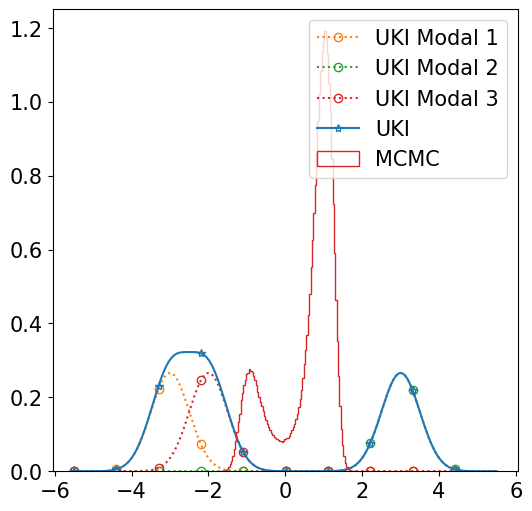

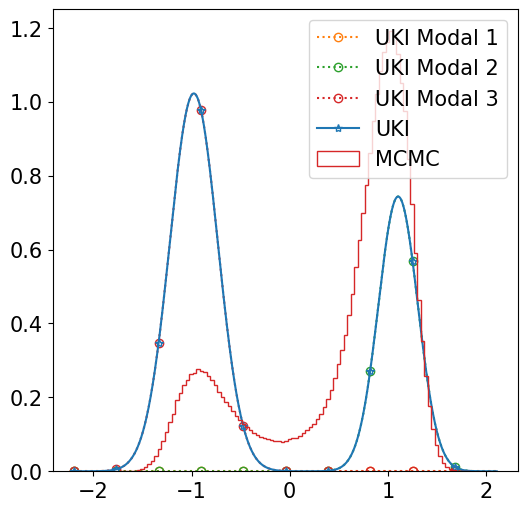

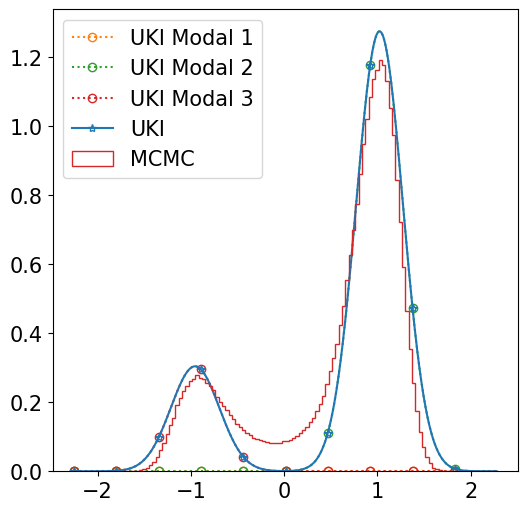

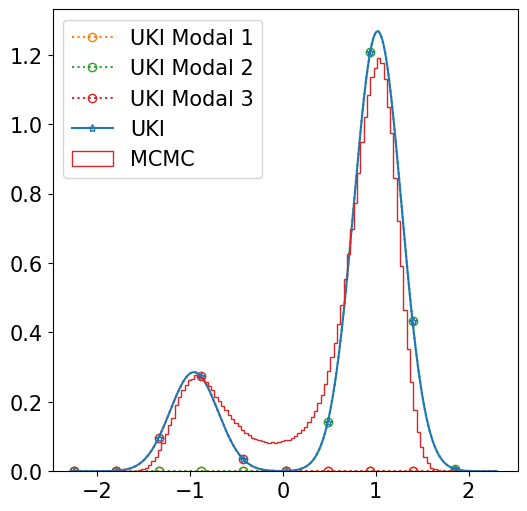

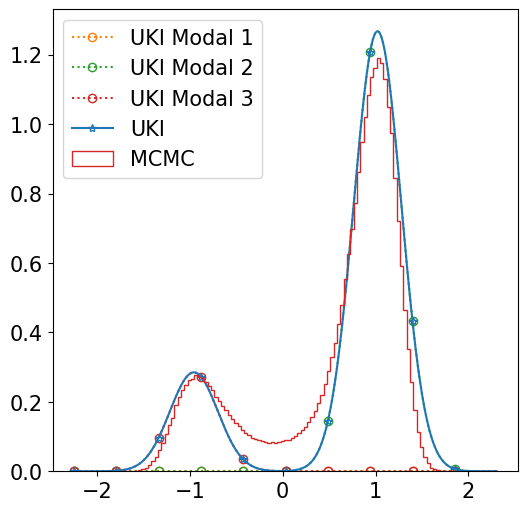

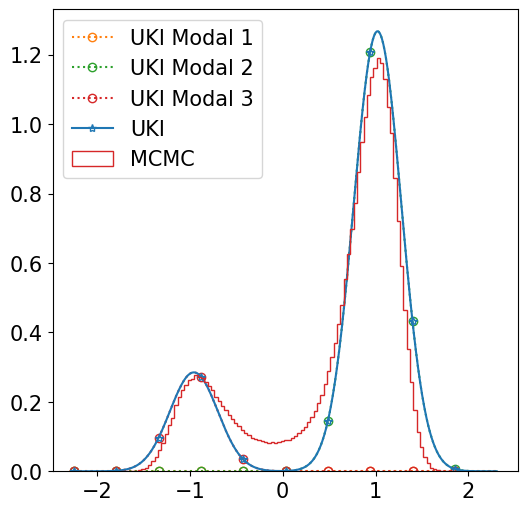

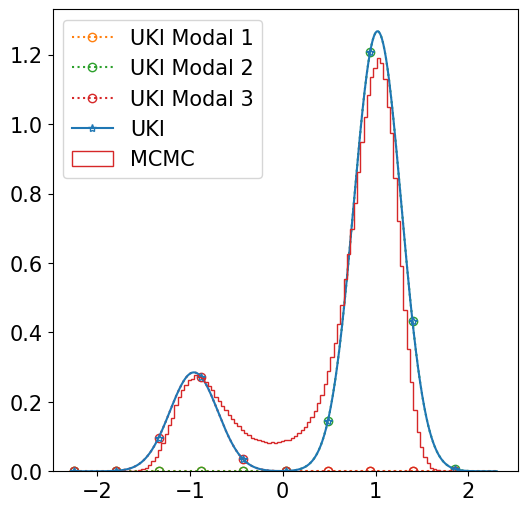

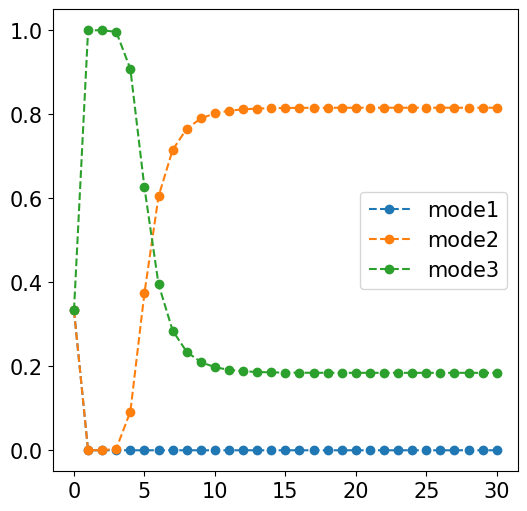

┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("prediction step  : θ_mean = ", [-3.0; 3.0; -2.0;;], " θ_p_mean = ", [-3.218276959568308; 2.9739783614351754; -1.8296466069254285;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:556
┌ Info: ("prediction step  : θ_mean = ", [-1.8120998228398764; 1.711138473851291; -1.234556828111148;;], " θ_p_mean = ", [-1.9404860203802061; 1.7035416381711121; -1.2454776972466128;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:556
┌ Info: ("prediction step  : θ_mean = ", [-1.6861123736819763; 1.421319131814547; -1.1046188300275002;;], " θ_p_mean = ", [-1.7830776691997061; 1.4135730162899762; -1.115491378112996;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:556
┌ Info: ("prediction step  : θ_mean = ", [-1.6235843838688402; 1

PyObject <matplotlib.legend.Legend object at 0x1afda31f0>

In [68]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 0.5, μ_0 = 3.0,  σ_0 = 2.0, Run_MCMC = true, plot_every = 5) 

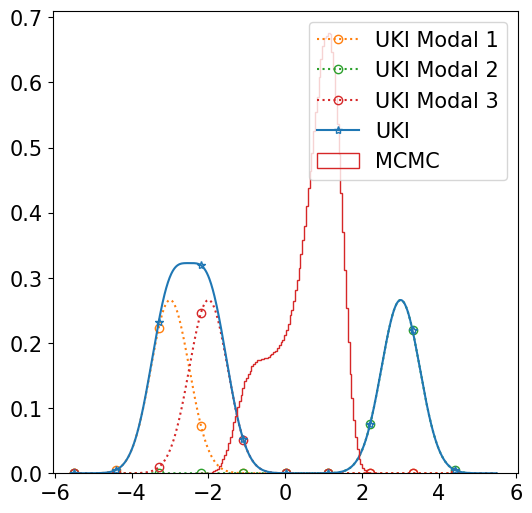

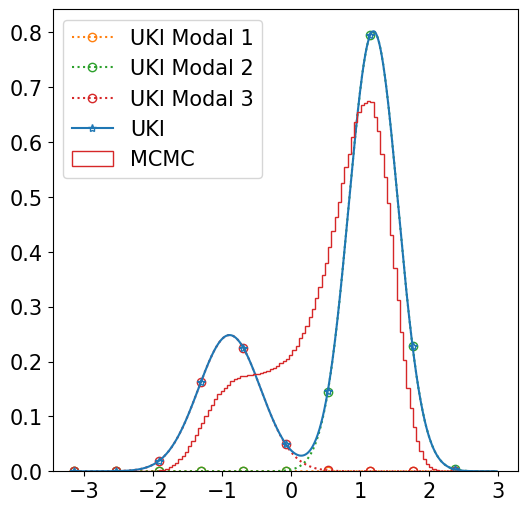

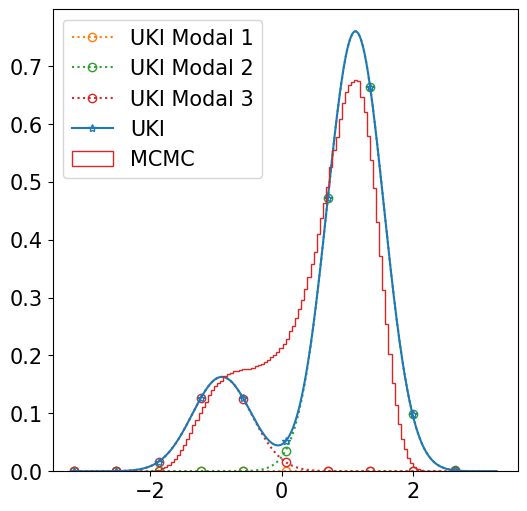

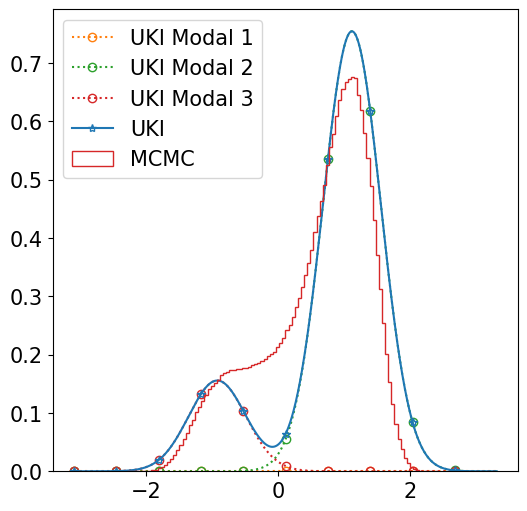

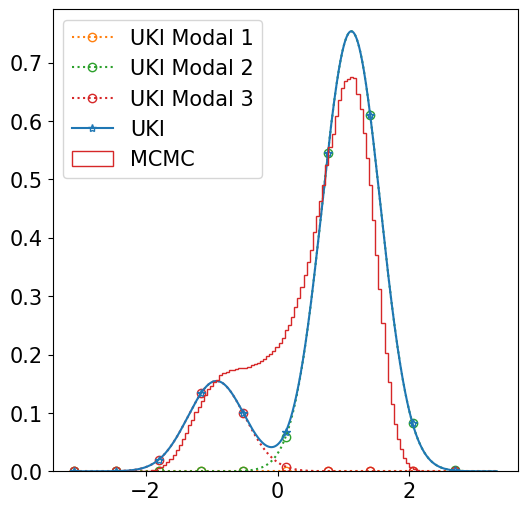

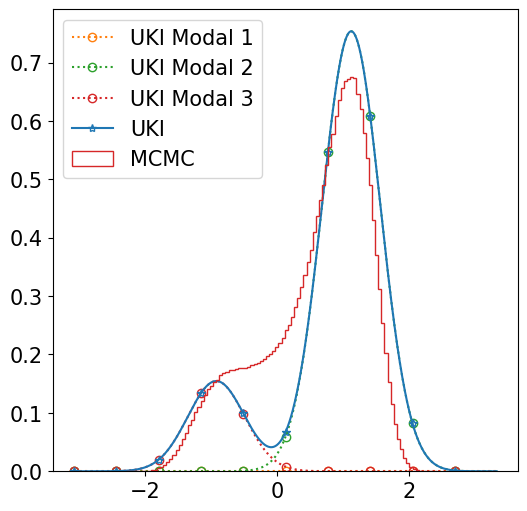

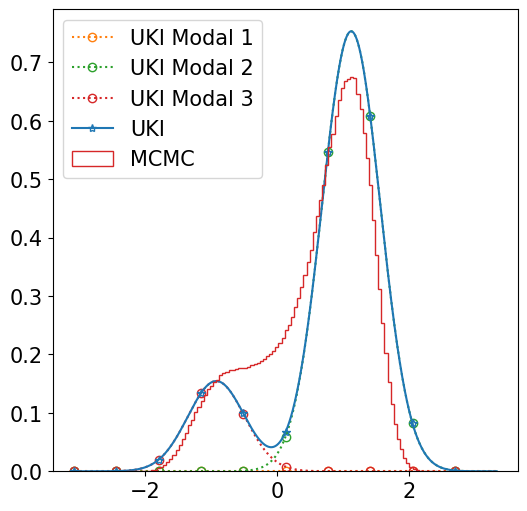

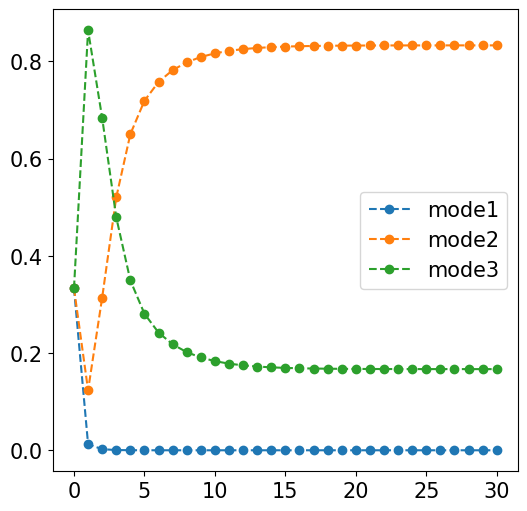

┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("prediction step  : θ_mean = ", [-3.0; 3.0; -2.0;;], " θ_p_mean = ", [-3.218276959568308; 2.9739783614351754; -1.8296466069254285;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:556
┌ Info: ("prediction step  : θ_mean = ", [-1.9084841148281455; 1.805752307428633; -1.308438990399985;;], " θ_p_mean = ", [-2.0659938642748696; 1.7932960604804682; -1.3158527667115953;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:556
┌ Info: ("prediction step  : θ_mean = ", [-1.7795622962398294; 1.5345322022900625; -1.124207000637038;;], " θ_p_mean = ", [-1.9084667720384938; 1.5224029675694493; -1.1443242842450356;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:556
┌ Info: ("prediction step  : θ_mean = ", [-1.711388520356083; 1

PyObject <matplotlib.legend.Legend object at 0x1af49bfd0>

In [69]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0, Run_MCMC = true, plot_every = 5) 

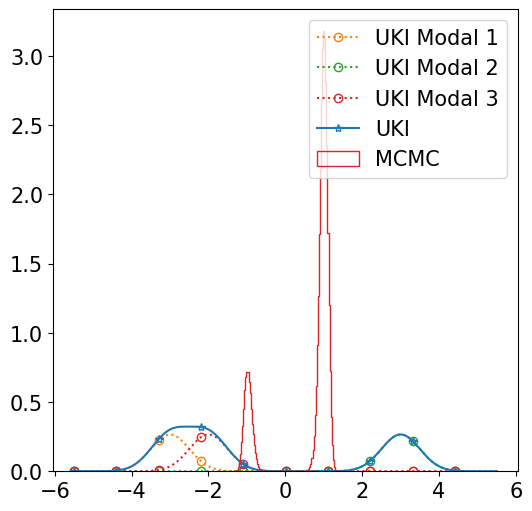

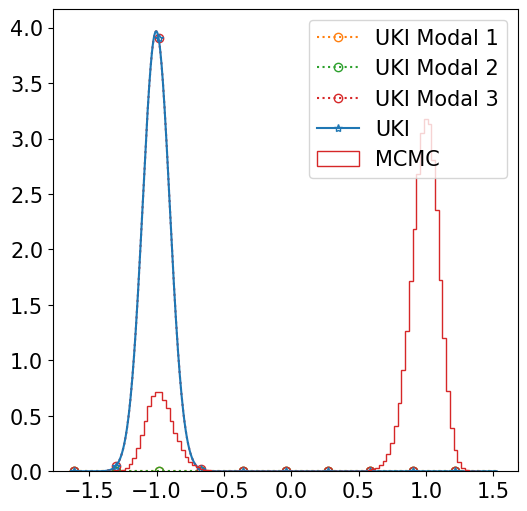

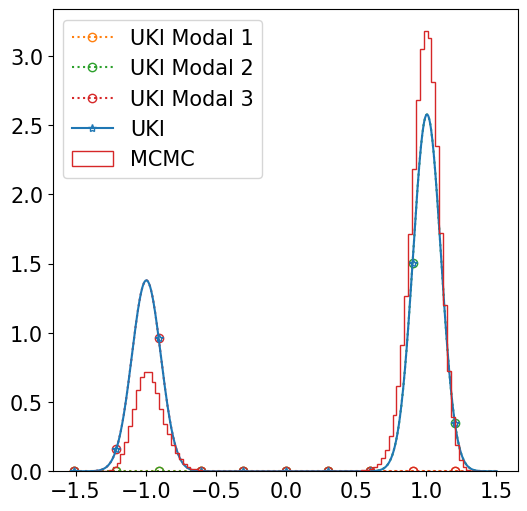

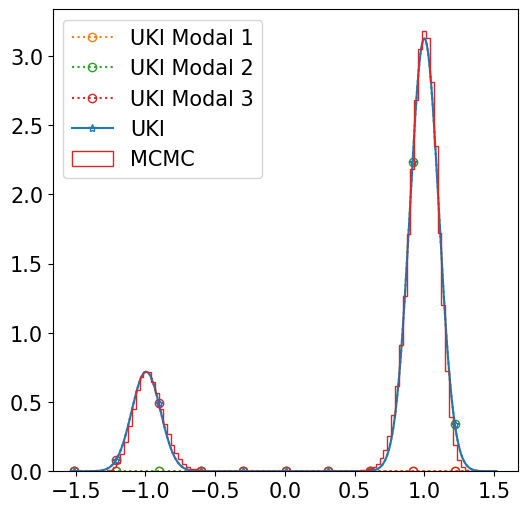

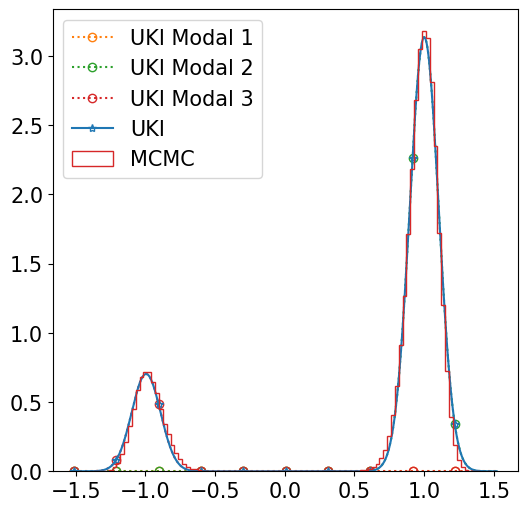

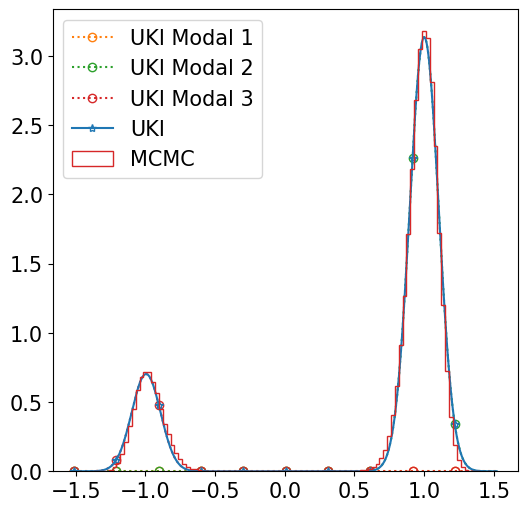

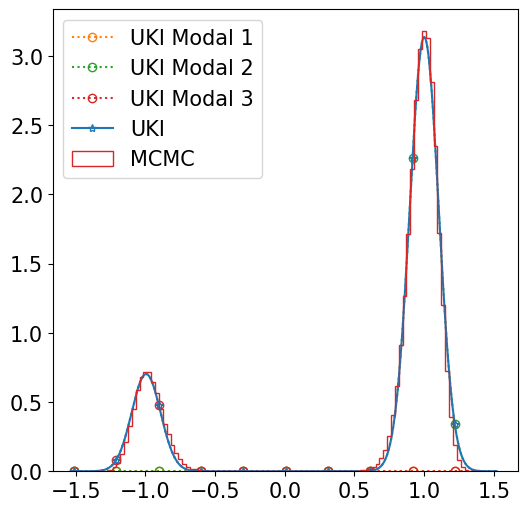

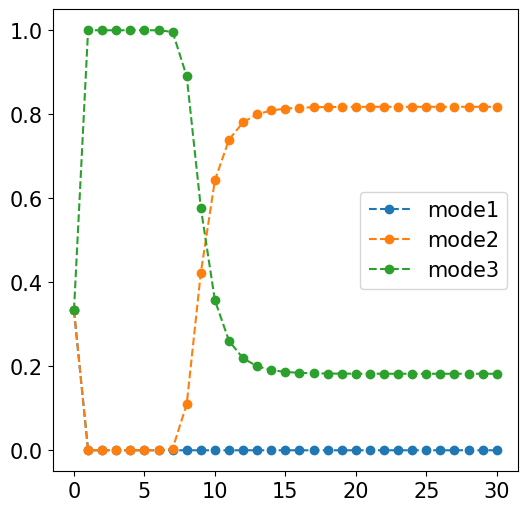

┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("prediction step  : θ_mean = ", [-3.0; 3.0; -2.0;;], " θ_p_mean = ", [-3.218276959568308; 2.9739783614351754; -1.8296466069254285;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:556
┌ Info: ("prediction step  : θ_mean = ", [-1.781770100001726; 1.6818405749828351; -1.2065451517038919;;], " θ_p_mean = ", [-1.8919912275596737; 1.9835746916163097; -1.2134264870880878;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:556
┌ Info: ("prediction step  : θ_mean = ", [-1.5390050338265502; 1.6122113032783238; -1.0661219312618404;;], " θ_p_mean = ", [-1.6204741005277237; 1.609580100182367; -1.0713487123285899;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:556
┌ Info: ("prediction step  : θ_mean = ", [-1.474758599575311; 

PyObject <matplotlib.legend.Legend object at 0x1b023ca30>

In [70]:
include("../../Inversion/KalmanInversion.jl")
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 0.2, μ_0 = 3.0,  σ_0 = 2.0, Run_MCMC = true, plot_every = 5) 